# DPU example: Yolo_v3

This notebooks shows how to run a YOLO network based application for object detection. The application, as well as the DPU IP, is pulled from the official [Vitis AI Github Repository](https://github.com/Xilinx/Vitis-AI).
For more information, please refer to the [Xilinx Vitis AI page](https://www.xilinx.com/products/design-tools/vitis/vitis-ai.html).

In this notebook we will be using the DNNDK **Python API** to run the DPU tasks.

## 1. Prepare the overlay
We will download the overlay onto the board. Then we will load the 
corresponding DPU model.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
overlay.load_model("dpu_tf_yolov3.elf")

## 2. Constants and helper functions 

You can view all of the helper functions in [DNNDK yolo example](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/tf_yolov3_voc.py). 
The helper functions released along with Vitis AI cover pre-processing of 
the images, so they can be normalized and resized to be compatible with 
the DPU model. These functions are included in our `pynq_dpu` package.

In [2]:
import numpy as np
import random
import cv2
import colorsys
from PIL import Image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
%matplotlib inline
from pynq_dpu.edge.dnndk.tf_yolov3_voc_py.tf_yolov3_voc import *

### Constants

Yolo V2 and V3 predict offsets from a predetermined set of boxes with 
particular height-width ratios; those predetermined set of boxes are the 
anchor boxes. We will use the predefined [anchors](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/model_data/yolo_anchors.txt).

In [3]:
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

We will use the `get_class()` function in `tf_yolov3_voc` module to
get class names from predefined [class names](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/image/voc_classes.txt).

In [5]:
classes_path = "img/voc_classes.txt"
class_names = get_class(classes_path)

Depending on the number of classes, we will define a unique color for each
class.

In [6]:
num_classes = len(class_names)
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

We can define some DPU-related parameters, such as DPU kernel name and
input/output node names.

In [7]:
KERNEL_CONV="tf_yolov3"
CONV_INPUT_NODE="conv2d_1_convolution"
CONV_OUTPUT_NODE1="conv2d_59_convolution"
CONV_OUTPUT_NODE2="conv2d_67_convolution"
CONV_OUTPUT_NODE3="conv2d_75_convolution"

### Drawing bounding boxes
We now define a custom function that draws the bounding boxes around 
the identified objects after we have the classification results.

In [8]:
def draw_boxes(image, boxes, scores, classes):
    _, ax = plt.subplots(1)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image_h, image_w, _ = image.shape

    for i, bbox in enumerate(boxes):
        [top, left, bottom, right] = bbox
        width, height = right - left, bottom - top
        center_x, center_y = left + width*0.5, top + height*0.5
        score, class_index = scores[i], classes[i]
        label = '{}: {:.4f}'.format(class_names[class_index], score) 
        color = tuple([color/255 for color in colors[class_index]])
        ax.add_patch(Rectangle((left, top), width, height,
                               edgecolor=color, facecolor='none'))
        ax.annotate(label, (center_x, center_y), color=color, weight='bold', 
                    fontsize=12, ha='center', va='center')
    return ax

### Predicting classes
We need to define a function that evaluates the scores and makes predictions
based on the provided class names.

In [9]:
def evaluate(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.2
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    boxes = []
    box_scores = []
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32

    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(
            yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), 
            input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)

    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)

    return boxes_, scores_, classes_

### Vector camera
Let's capture an image from vector robot.

12:09:07.826               robot.Robot WARNING  No serial number or name provided. Automatically selecting 0060497d
12:09:07.851     connection.Connection    INFO  Connecting to 192.168.0.236:443 for Vector-X7H6 using /root/.anki_vector/Vector-X7H6-0060497d.cert
12:09:09.493     connection.Connection    INFO  BehaviorControl control_granted_response { }
12:09:09.963       events.EventHandler WARNING  Unknown Event type
12:09:10.435       events.EventHandler WARNING  Unknown Event type
12:09:11.099       events.EventHandler WARNING  Unknown Event type
12:09:11.947       events.EventHandler WARNING  Unknown Event type
12:09:12.659       events.EventHandler WARNING  Unknown Event type


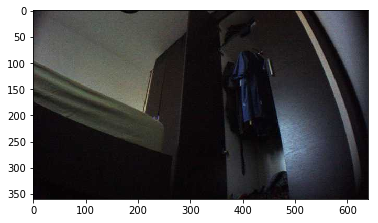

In [10]:
import anki_vector
from anki_vector.util import degrees

raw_image = None
image = None

with anki_vector.Robot() as robot:
    # If necessary, move Vector's Head and Lift down
    robot.behavior.set_head_angle(anki_vector.behavior.MAX_HEAD_ANGLE)
    robot.behavior.set_lift_height(0.0)
    
    robot.camera.init_camera_feed()
    raw_image = robot.camera.latest_image.raw_image
    image = cv2.cvtColor(np.asarray(raw_image),cv2.COLOR_RGB2BGR)
    
_, ax = plt.subplots(1)
_ = ax.imshow(raw_image)


The following cell will normalize the input picture size.

In [11]:
image_size = image.shape[:2]
image_data = np.array(pre_process(image, (416, 416)), dtype=np.float32)

## 3. Run application

We create DPU kernel and task.

In [12]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
task = n2cube.dpuCreateTask(kernel, 0)

Now we execute the DPU task to classify an input picture.

In [13]:
input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
n2cube.dpuSetInputTensorInHWCFP32(
    task, CONV_INPUT_NODE, image_data, input_len)

n2cube.dpuRunTask(task)

conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
conv_out1 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE1, 
                                               conv_sbbox_size)
conv_out1 = np.reshape(conv_out1, (1, 13, 13, 75))

conv_mbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE2)
conv_out2 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE2, 
                                               conv_mbbox_size)
conv_out2 = np.reshape(conv_out2, (1, 26, 26, 75))

conv_lbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE3)
conv_out3 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE3, 
                                               conv_lbbox_size)
conv_out3 = np.reshape(conv_out3, (1, 52, 52, 75))

yolo_outputs = [conv_out1, conv_out2, conv_out3]    

We can call the `evaluate()` function defined previously now. Depending on
how many objects can be identified in the picture, the function returns
a list of bounding box coordinates, a list of probability scores, and a list
of class indexes.

In [14]:
boxes, scores, classes = evaluate(yolo_outputs, image_size, 
                                  class_names, anchors)

Once we have all the bounding boxes, classes, and scores, we can feed them to
the `draw_boxes()` function to draw the bounding boxes over each recognized object.

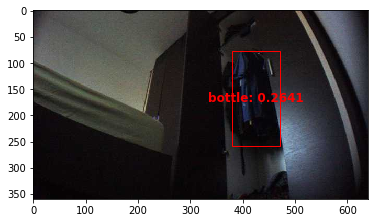

In [15]:
_ = draw_boxes(image, boxes, scores, classes)

The above cell probably only shows 1 class. Keep in mind that the model
is able to identify multiple projects in the given picture.
You can try a different picture by specifying a new `image_path`. 

Remember to clean up when you are done.

In [16]:
n2cube.dpuDestroyTask(task)
n2cube.dpuDestroyKernel(kernel)

0

Copyright (C) 2020 Xilinx, Inc.